In [1]:
# Modified: 25/10/2020 by DD
#
# In this quick start practical tutorial, you will learn how to get the noise scaling factors from
# a number of S1 Level-1 GRD training files.
# The processing comprises two stages. 1st is related to the method called 'experiment_noiseScaling'
# of the 'Sentinel1Image' class to obtain statistics for each individual training file.
# The aggregated statistics processing is the second stage of the method and implemnted as a
# python script called 'analyze_experiment_noiseScalingParameters.py'.
# In this tutorial we follow the mentioned implementation almost line by line.

In [2]:
# Pre-requerments: It is assumed that you have downloaded and installed Sentinel1Denoised package:
# https://github.com/nansencenter/sentinel1denoised/tree/master

In [3]:
########################################################################
# Stage 1. Processing of individual training files (S1 Level-1 GRD)    #
########################################################################

In [17]:
# First you need to import Sentinel1Image class and open 
# a S1 Level1 GRD file (IW GRDH in our case, replace with yours)
# Note: In our example we process the only one training file but in real data processing you need to use tens of files
# in batch manner

from s1denoise import Sentinel1Image
import numpy as np
from scipy.optimize import fminbound
s1 = Sentinel1Image('/mnt/sverdrup-2/sat_auxdata/denoise/dolldrums/zip/S1A_IW_GRDH_1SDV_20200607T075151_20200607T075220_032908_03CFD7_9E14.zip')

01:16:27|40|nansat|_get_dataset_metadata|GDAL could not open /mnt/sverdrup-2/sat_auxdata/denoise/dolldrums/zip/S1A_IW_GRDH_1SDV_20200607T075151_20200607T075220_032908_03CFD7_9E14.zip, trying to read with Nansat mappers...


In [8]:
# We further go almost in line by line manner through the method called 'experiment_noiseScaling'

In [5]:
# Clip size of side pixels, ~1km
cPx = {'IW':100, 'EW':25}[s1.obsMode]
# Define polarization of the data we want to process
polarization = 'VH'

In [81]:
# Call 'subswathIndexMap' method to get matrix with sub-swath numbers consistent with the data grid
subswathIndexMap = s1.subswathIndexMap(polarization)

In [82]:
# Print out the matrix
subswathIndexMap

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3]], dtype=uint8)

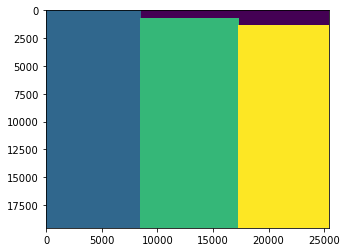

In [83]:
# Lets visualize the sub-swath numbers
# Color corresponds to different sub-swath. In our case:
# blue - 1, green - 2, yellow - 3, black - no data
import matplotlib.pyplot as plt
plt.clf()
plt.imshow(subswathIndexMap)

In [8]:
# To mask areas over land, we call 'landmask'
landmask = s1.landmask(skipGCP=4)

In [10]:
# Get matrices of calibrated raw sigma zero and NESZ from ESA-provided annotaion files
sigma0 = s1.rawSigma0Map(polarization)
noiseEquivalentSigma0 = s1.rawNoiseEquivalentSigma0Map(polarization, lutShift=True)    

In [11]:
# Get the line indexes where we have data for the each element in range ditrection
import numpy as np
validLineIndices = np.argwhere(np.sum(subswathIndexMap!=0,axis=1)==s1.shape()[1])

In [12]:
# Define number of lines to averge (block height), in our case 1000 px
# and calculate the block bounds
numberOfLinesToAverage = 1000
blockBounds = np.arange(validLineIndices.min(), validLineIndices.max(),
                                numberOfLinesToAverage, dtype='uint')

In [13]:
# Print out block bounds coordinates (pixel indexes)
blockBounds

array([ 1367,  2367,  3367,  4367,  5367,  6367,  7367,  8367,  9367,
       10367, 11367, 12367, 13367, 14367, 15367, 16367, 17367, 18367,
       19367], dtype=uint64)

In [84]:
# Prepare a dictonary for results for each sub-block in each sub-swath
# sigma0 is a vector that is mean range profile
# noiseEquivalentSigma0 is a vector with ESA-provided mean range noise profile
# scalingFactor is a value with intermediate noise scaling factor
# correlationCoefficient is a value with correlation coefficient between raw sigma0 and scaled nosie
# fitResidual is a value with error of fitting of the seclected scaling factor (K)
results = { '%s%s' % (s1.obsMode, li):
                        { 'sigma0':[],
                          'noiseEquivalentSigma0':[],
                          'scalingFactor':[],
                          'correlationCoefficient':[],
                          'fitResidual':[] }
                    for li in range(1, {'IW':3, 'EW':5}[s1.obsMode]+1) }

In [85]:
# Loop over blocks
for iBlk in range(len(blockBounds)-1):
    # Check if there is no pixels over land areas
    if landmask[blockBounds[iBlk]:blockBounds[iBlk+1]].sum() != 0:
        continue
    
    # Slicing 2D arrays for each block
    # sigma0
    blockS0 = sigma0[blockBounds[iBlk]:blockBounds[iBlk+1],:]   
    # raw ESA noise
    blockN0 = noiseEquivalentSigma0[blockBounds[iBlk]:blockBounds[iBlk+1],:]
    # Sub-swath indices for the block
    blockSWI = subswathIndexMap[blockBounds[iBlk]:blockBounds[iBlk+1],:]
    
    # An arbitrary empirical adjustment.
    # When the number of valid range pixels is too small, it is hard to get reliable estimation.
    # By allowing the use of some pixels with negative values, the number of range pixels to be used 
    # for fitting increases.
    # In short, it can be any value but we set it as 0.5 for no special reason.
    pixelValidity = (np.nanmean(blockS0 - blockN0 * 0.5, axis=0) > 0) 

    fitCoefficients = []
    
    # Loop over sub-blocks in sub-swaths
    for iSW in range(1, {'IW': 3, 'EW': 5}[s1.obsMode]+1):
        subswathID = '%s%s' % (s1.obsMode, iSW)
        # Get valid pixel indices based on 'pixelValidity'
        pixelIndex = np.nonzero((blockSWI==iSW).sum(axis=0) * pixelValidity)[0][cPx:-cPx]
        if pixelIndex.sum()==0:
            continue
            
        # Compute mean range profiles for sub-block by averaging in azimuth direction
        meanS0 = np.nanmean(np.where(blockSWI==iSW, blockS0, np.nan), axis=0)[pixelIndex]
        meanN0 = np.nanmean(np.where(blockSWI==iSW, blockN0, np.nan), axis=0)[pixelIndex]
        
        # Calculate weight that is proportional to gradient of sigma0 that takes account of sigma0 varying
        weight = abs(np.gradient(meanN0))
        # Normilize the weight
        weight = weight / weight.sum() * np.sqrt(len(weight))
        
        # Polyfit is used only to return error (second return param) when fitting func:
        # s0-k*no = f(A*x + B). Where:
        # s0 - sigma0
        # n0 - ESA-provided thermal noise
        # k - noise scaling (to be identified at later stage of fitting)
        # x - pixel index
        # A, B - just some polynom coeffs that are not used
        errFunc = lambda k,x,s0,n0,w: np.polyfit(x,s0-k*n0,w=w,deg=1,full=True)[1].item()
        
        # Now with polynom fitting function in place, K (the noise scaling coefficient)
        # is fitted iteratively using 'fminbound' method from NumPy for the interval of 0 to 3dB
        scalingFactor = fminbound(errFunc, 0, 3,
            args=(pixelIndex,meanS0,meanN0,weight), disp=False).item()
        # Value of correlation coefficient between sigma0 and scaled noise
        correlationCoefficient = np.corrcoef(meanS0, scalingFactor * meanN0)[0,1]
        # Value of error of the fitting of the selected scaling factor (K)
        fitResidual = np.polyfit(pixelIndex, meanS0 - scalingFactor * meanN0,
                                 w=weight, deg=1, full=True)[1].item()

        # Append results to the list
        results[subswathID]['sigma0'].append(meanS0)
        results[subswathID]['noiseEquivalentSigma0'].append(meanN0)
        results[subswathID]['scalingFactor'].append(scalingFactor)
        results[subswathID]['correlationCoefficient'].append(correlationCoefficient)
        results[subswathID]['fitResidual'].append(fitResidual)
                
# Save the results for individual file in NPZ format
np.savez(s1.name.split('.')[0] + '_noiseScaling.npz', **results)

# At this point we obtained statistics for many files and ready to the 2nd stage that is
# aggregated statistics processing

In [86]:
################################################
# Stage 2. Processing of aggregated statistics #
################################################

In [87]:
# Once we have statistics for the training files we may start stage 2 to get final results on the noise scaling

In [89]:
# Initialize empty lists for aggregated results for each sub-swath from each npz file
powerDifference = {'%s%s' % (s1.obsMode, li): [] for li in range(1, ({'IW':3, 'EW':5}[s1.obsMode]+1))}
scalingFactor = {'%s%s' % (s1.obsMode, li): [] for li in range(1, ({'IW':3, 'EW':5}[s1.obsMode]+1))}
correlationCoefficient = {'%s%s' % (s1.obsMode, li): [] for li in range(1, ({'IW':3, 'EW':5}[s1.obsMode]+1))}
fitResidual = {'%s%s' % (s1.obsMode, li): [] for li in range(1, ({'IW':3, 'EW':5}[s1.obsMode]+1))}

In [90]:
# Get the list of npz files with individual statistics
import glob
npzFiles = glob.glob('*noiseScaling*.npz')

# Loop over the files
for npzFile in npzFiles:
    print('importing %s' % npzFile)
    npz = np.load(npzFile)
    npz.allow_pickle = True
    
    for iSW in range(1, ({'IW': 3, 'EW': 5}[s1.obsMode])+1):    
        # Get number of sub-blocks
        numberOfSubblocks = np.unique([
                    len(npz['%s%s' % (s1.obsMode,iSW)].item()[key])
                    for key in ['scalingFactor', 'correlationCoefficient', 'fitResidual']])
        
        # Check if the number of sub-blocks is consistent for all parameters
        if numberOfSubblocks.size != 1:
                print('*** numberOfSubblocks are not consistent for all estimations.')
                continue
        # Unpack the number of sub-blocks
        numberOfSubblocks = numberOfSubblocks.item()
        
        # Calculate a value of intermediate sigma0 value for each sub-block
        powerDifference['%s%s' % (s1.obsMode,iSW)].append([
                  np.nanmean(10*np.log10(npz['%s%s' % (s1.obsMode,iSW)].item()['sigma0'][li]))
                - np.nanmean(10*np.log10(npz['%s%s' % (s1.obsMode,iSW)].item()['noiseEquivalentSigma0'][li]))
                for li in range(numberOfSubblocks) ])
        
        # Collect a set of values of scaling factors, correlation coefficients and residuals for each sub-block
        scalingFactor['%s%s' % (s1.obsMode,iSW)].append(npz['%s%s' % (s1.obsMode,iSW)].item()['scalingFactor'])
        correlationCoefficient['%s%s' % (s1.obsMode,iSW)].append(npz['%s%s' % (s1.obsMode,iSW)].item()['correlationCoefficient'])
        fitResidual['%s%s' % (s1.obsMode,iSW)].append(npz['%s%s' % (s1.obsMode,iSW)].item()['fitResidual'])

importing S1A_IW_GRDH_1SDV_20200607T075151_20200607T075220_032908_03CFD7_9E14_noiseScaling.npz


In [78]:
# Initialize lists for noise scaling parameters and their confidence intervals for final results
noiseScalingParameters = {'%s%s' % (s1.obsMode, li): {} for li in range(1, ({'IW':3, 'EW':5}[s1.obsMode]+1))}
noiseScalingParametersRMSE = {'%s%s' % (s1.obsMode, li): {} for li in range(1, ({'IW':3, 'EW':5}[s1.obsMode]+1))}

# Loop over sub-swaths to obtain final noise scaling factors for each sub-swath
for iSW in range(1, ({'IW': 3, 'EW': 5}[s1.obsMode])+1):   
    # Open agregated lists of parameters as NumPy vector for sub-swath
    # Vector of intermediate sigma0
    pd = np.hstack(powerDifference['%s%s' % (s1.obsMode,iSW)])
    # Vector of of noise scaling factor
    sf = np.hstack(scalingFactor['%s%s' % (s1.obsMode,iSW)])
    # vector of correaltion coefficient between raw sigma0 and scaled nosie
    cc = np.hstack(correlationCoefficient['%s%s' % (s1.obsMode,iSW)])
    # Vector of errors of fitting of the scaling factor (K)
    fr = np.hstack(fitResidual['%s%s' % (s1.obsMode,iSW)])

    # Calculate vector with weights for fitting: higher weights for high correlation and low RMSE from K-fitting
    w = cc / fr
    
    # Note: Fitting of K to powerDifference with degree=0
    # Here we find optimal value of K (just one value since degree of fitted polynom is 0).
    # That optimal value corresponds to:
    #  * high density of powerDifference values: This high density appears where powerDifference
    #    is low. I.e. where signal is low (low wind conditions).
    #  * high weights: where correlation is high and rmse is low
    # y using this fitting we avoid neccesity to choose scenes with low wind manualy.
    fitResults = np.polyfit(pd, sf, deg=0, w=w)

    # Results
    # Noise scaling coefficient
    noiseScalingParameters['%s%s' % (s1.obsMode,iSW)] = fitResults[0]
    # Confidence interval
    noiseScalingParametersRMSE['%s%s' % (s1.obsMode,iSW)] = np.sqrt(np.sum((fitResults[0]-sf)**2 * w) / np.sum(w))

In [99]:
# Now we obtained noise scaling factors for each sub-swath as well as
# their confident intervals and may print it out

print('Noise scaling parameters for each sub-swath:\n%s' % noiseScalingParameters)
print('\nConfidence intervals:\n%s' % noiseScalingParametersRMSE)

Noise scaling parameters for each sub-swath:
{'IW1': 1.0525003487515774, 'IW2': 1.003359997763131, 'IW3': 1.0945965379679081}

Confidence intervals:
{'IW1': 0.03060775683092379, 'IW2': 0.00967053603311147, 'IW3': 0.009314693037954078}
